# 1. Понимание бизнеса

## 1.1. Цель
Определение качества вина по 10 бальной шкале

## 1.2. Описание

Два набора данных относятся к красному и белому вариантам португальского вина «Vinho Verde». Ссылка [Cortez et al., 2009]. Из соображений конфиденциальности и логистики доступны только физико-химические (входные) и органолептические (выходные) переменные (например, нет данных о сортах винограда, марке вина, продажной цене вина и т. д.).

Два набора данных были объединены, и несколько значений были удалены случайным образом.

# 2. Понимание данных

## 2.1. Подключение библиотек, загрузка данных на диск

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/kaggle/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d 'rajyellow46/wine-quality' 
!unzip /content/wine-quality.zip

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
wine-quality.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/wine-quality.zip
replace winequalityN.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: winequalityN.csv        


In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
import shap

import warnings
warnings.filterwarnings('ignore')

## 2.2. Описание данных

Информация об атрибутах:

Для получения дополнительной информации см. [Cortez et al., 2009].
Входные переменные (на основе физико-химических тестов):

1 - фиксированная кислотность

2 - летучая кислотность

3 - лимонная кислота

4 - остаточный сахар

5 - хлориды

6 - свободный диоксид серы

7 - общий диоксид серы

8 - плотность

9 - рН

10 - сульфаты

11 - спирт

Выходная переменная (на основе сенсорных данных):
12 - качество (оценка от 0 до 10)

## 2.3. Посмотрим данные

In [ ]:
data = pd.read_csv('/content/winequalityN.csv')
data

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### 2.3.1. Посмотрим на пропуски и нулевые значения
В % соотношении

In [ ]:
data.isna().sum()/data.shape[0]*100

type                    0.000000
fixed acidity           0.153917
volatile acidity        0.123134
citric acid             0.046175
residual sugar          0.030783
chlorides               0.030783
free sulfur dioxide     0.000000
total sulfur dioxide    0.000000
density                 0.000000
pH                      0.138525
sulphates               0.061567
alcohol                 0.000000
quality                 0.000000
dtype: float64

### **Пропуски присутствуют**

In [ ]:
white = 100*data[data['type'] == 'white'].shape[0]/data.shape[0]
print(f'white: {round(white, 4)} %')

red = 100*data[data['type'] == 'red'].shape[0]/data.shape[0]
print(f'red: {round(red, 4)} %')

white: 75.3886 %
red: 24.6114 %


### 2.3.2 Статистика и визуализация

In [ ]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


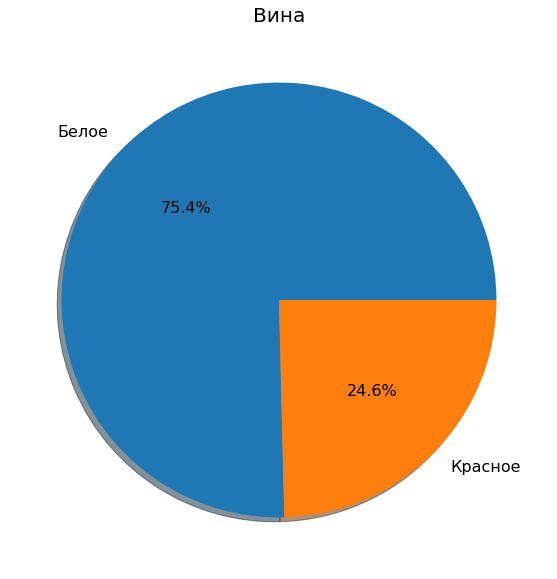

In [ ]:
plt.figure(figsize=(10, 10))
plt.pie([white, red], labels=['Белое', 'Красное'], autopct='%1.1f%%', shadow=True, textprops = {"fontsize":16})
plt.title(label='Вина', fontsize=20)
plt.show()

Text(0.5, 1.0, 'Зависимость качества вина от % спирта')

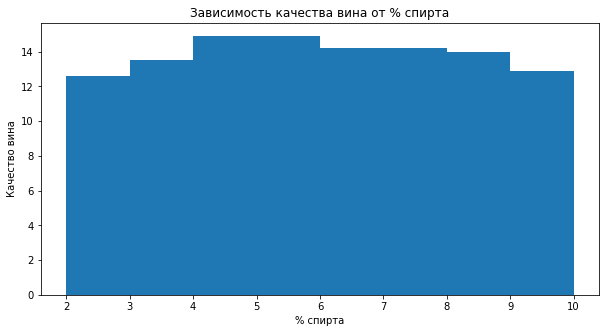

In [ ]:
x = np.linspace(0, 2, 100)  # Sample data.

fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(data['quality'], data['alcohol'], 2)
ax.set_xlabel('% спирта')
ax.set_ylabel('Качество вина')
ax.set_title("Зависимость качества вина от % спирта") 

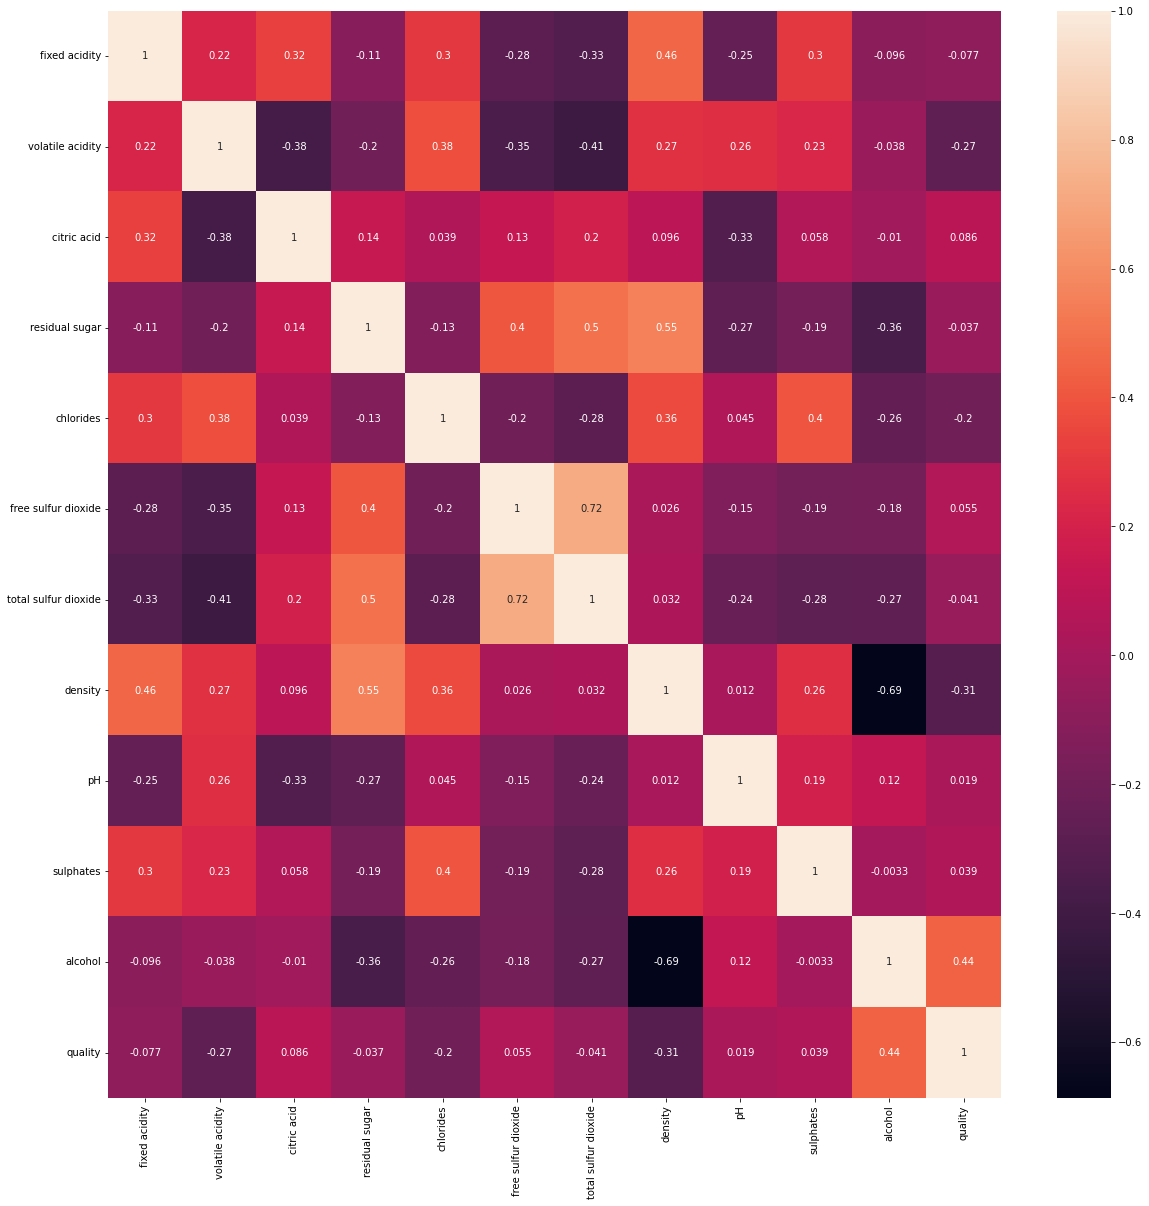

In [ ]:
corr = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True);

# 3. Подготовка данных

## 3.1. Заполняем пропущенные данные средними значениями

In [ ]:
data_new = data.fillna(data.mean())

In [ ]:
# Теперь пропущенных значений нет
data_new.isna().sum()/data_new.shape[0]*100

type                    0.0
fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64

## 3.2. Переведём категориальные признаки в числовые

In [ ]:
data_dum = pd.get_dummies(data_new)
data_result = data_dum.to_numpy()

## 3.3. Создаём датасет

In [ ]:
train_X , test_X , train_y , test_y = train_test_split(data_result[:, 0:12], data_result[:, 13], train_size = 0.8)

In [ ]:
print('train_x:', train_X.shape, train_y.shape, '\n', 'test_x:', test_X.shape, test_y.shape)

train_x: (5197, 12) (5197,) 
 test_x: (1300, 12) (1300,)


## 3.3. Нормализуем данные

In [ ]:
scaler = StandardScaler()
scaler.fit(train_X)

StandardScaler()

In [ ]:
train_x = scaler.fit_transform(train_X)
test_x = scaler.fit_transform(test_X)

In [ ]:
print(train_x.shape, '\n', train_x[0:4])

(5197, 12) 
 [[ 0.68649182 -0.54509462  0.41984266 -0.35157472 -0.14640338 -0.70912991
   0.2320775  -0.63947809 -0.05565266 -1.02207768  0.85100923  0.21010234]
 [ 0.14374849 -0.90821687 -0.12949607  1.53107761 -0.0904478   1.01179572
   1.69539277  1.29070115 -0.49028174 -0.2788311  -1.16562009  1.36068384]
 [-0.0888558  -0.3635335  -0.26683075  0.63158816 -0.73393702 -0.31416337
   1.32515638 -0.44646017 -0.366102   -0.48153471  1.43919278  1.36068384]
 [ 1.38430467  0.6047925   1.17518341 -0.64443175  0.608997   -0.25773958
   0.09103506  1.02446953  0.06852707  0.32927975 -1.08159387 -0.94047917]]


# 4. Modeling
Сравним 2 модели:

*   Новый пункт
*   RandomForestRegressor



## 4.1. LinearRegression

In [ ]:
reg = LinearRegression()
reg.fit(train_x, train_y)

LinearRegression()

In [ ]:
print('Точность на train:', reg.score(train_x, train_y))
print('Точность на test:', reg.score(test_x, test_y))

Точность на train: 0.8585489498186208
Точность на test: 0.8767041272398238


## 4.2. LinearSVR

In [ ]:
svr = LinearSVR(random_state=12)
svr.fit(train_x, train_y)

LinearSVR(random_state=12)

In [ ]:
print('Точность на train:', svr.score(train_x, train_y))
print('Точность на test:', svr.score(test_x, test_y))

Точность на train: 0.8498503034605879
Точность на test: 0.8769101547799583


## 4.3. RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(max_depth=2, random_state=12)
rfr.fit(train_x, train_y)

RandomForestRegressor(max_depth=2, random_state=12)

In [ ]:
print('Точность на train:', rfr.score(train_x, train_y))
print('Точность на test:', rfr.score(test_x, test_y))

Точность на train: 0.8541868949823874
Точность на test: 0.873299029899874


## 4.4. Ансамблирование (Stacking)

In [ ]:
estimators = [
  ('lr', LinearRegression()),
  ('svr', LinearSVR(random_state=12)),
  ('rfr', RandomForestRegressor(max_depth=2, random_state=12))
]
stack = StackingRegressor(
  estimators=estimators,
  final_estimator=RandomForestRegressor(n_estimators=10, random_state=12)
)

In [ ]:
stack.fit(train_x, train_y)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('svr', LinearSVR(random_state=12)),
                              ('rfr',
                               RandomForestRegressor(max_depth=2,
                                                     random_state=12))],
                  final_estimator=RandomForestRegressor(n_estimators=10,
                                                        random_state=12))

In [ ]:
print('Точность на train:', stack.score(train_x, train_y))
print('Точность на test:', stack.score(test_x, test_y))

Точность на train: 0.9746607326155976
Точность на test: 0.9855977312954614


## **C помощью стекинга увеличил точность**

# 5. Оценка

## 5.1. Оценка точности

Лучшее решение показал ансамбль 3 моделей (стекинг)

In [ ]:
print('Точность на train:', stack.score(train_x, train_y))
print('Точность на test:', stack.score(test_x, test_y))

Точность на train: 0.9746607326155976
Точность на test: 0.9855977312954614


## 5.2. Интерпритация влияния признаков на SHAP
Для ускорения работы возьмём всего 100 строк

  0%|          | 0/100 [00:00<?, ?it/s]

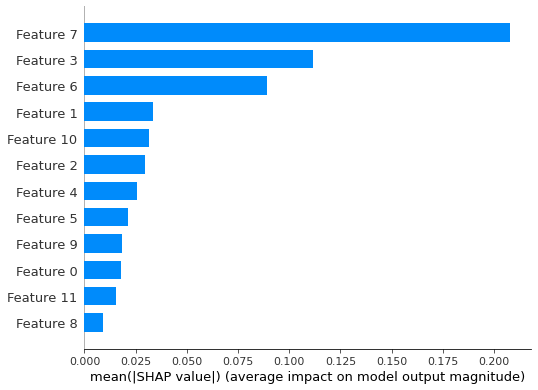

In [ ]:
shap.initjs()
explainer = shap.KernelExplainer(stack.predict, test_x[0:100])
shap_values = explainer.shap_values(test_x[0:100], nsamples=20)
# shap.summary_plot(shap_values, test_x[0:100], max_display=15, auto_size_plot=True)
shap.summary_plot(shap_values, test_x[0:100], plot_type="bar")

# 6. Развертывание

In [ ]:
y_pred = stack.predict(test_x)
y_pred.shape

df_pred = pd.DataFrame(y_pred)

df_pred.to_csv('y_pred.csv', index = False)